In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
import requests
import json
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/covid19countryinfo.csv
./input/SIR_data.csv
./input/states-daily.csv
./input/covid19-deepscore.csv
./input/population_data.csv
./input/full-list-total-tests-for-covid-19.csv
./input/country_codes.csv
./input/enriched_covid_19_week_2.csv
./input/covid19-global-forecasting-week-3/test.csv
./input/covid19-global-forecasting-week-3/submission.csv
./input/covid19-global-forecasting-week-3/train.csv
./input/korea/SeoulFloating.csv
./input/korea/TimeAge.csv
./input/korea/SearchTrend.csv
./input/korea/TimeProvince.csv
./input/korea/Weather.csv
./input/korea/PatientRoute.csv
./input/korea/PatientInfo.csv
./input/korea/Region.csv
./input/korea/TimeGender.csv
./input/korea/Case.csv
./input/korea/Time.csv
./input/covid19-global-forecasting-week-2/test.csv
./input/covid19-global-forecasting-week-2/submission.csv
./input/covid19-global-forecasting-week-2/train.csv
./input/covidAPI/ESP.json
./input/covidAPI/ICL.json
./input/covidAPI/CHN.json
./input/covidAPI/FRA.json
./input/covidAPI/THA.json

In [5]:
days_in_sequence = 21
output_days = 7

sequence_length = days_in_sequence - 1
training_percentage = 0.9
temp_dim = 1

In [7]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,temp_dim))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
dense_f = layers.Dense(16)(rnn_f)
dropout_f = layers.Dropout(0.2)(dense_f)
output_f = layers.Dense(7)(dropout_f)
removed = layers.LeakyReLU(alpha=0.1, name="removed")(output_f)

model = Model([temporal_input_layer], [removed])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 20, 1)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 64)            16896     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 119       
_________________________________________________________________
removed (LeakyReLU)          (None, 7)                 0         
Total para

In [8]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.6), #patience=4  #EarlyStopping(monitor='val_loss', patience=20)
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.mean_squared_logarithmic_error], optimizer="adam")

In [9]:
model.load_weights("best_removed_model.h5")

In [10]:
#Will retrieve the number of cases and fatalities for the past 14
def build_inputs_for_date_code(code, date, gdf):
    start_date = date - timedelta(days=days_in_sequence-1) # input start date
    end_date = date - timedelta(days=1) # input end date
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    tdf = gdf[(gdf["Code"] == code) & (gdf["Date"] >= str_start_date) & (gdf["Date"] <= str_end_date)]

    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([tdf["removed_noise_rate"]]),
                                     (temp_dim,sequence_length)), (1,0) ).astype(np.float32)
    
    return [np.array([temporal_input_data])]

In [11]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_code(code, pdf, gdf):
    tdf = pdf[pdf["Code"]==code]
    # begin_prediction = "2020-03-26"
    begin_prediction = tdf.iloc[0]["Date"]
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d") + timedelta(days_in_sequence) #start of the prediction date
    print("prediction start date: {}".format(datetime.strftime(start_date, "%Y-%m-%d")))
    # end_prediction = "2020-04-15"
    end_prediction = tdf.iloc[-1]["Date"]
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days+1, output_days+1)]
    for date in date_list:
        date_until = date + timedelta(days=output_days-1)
        input_data = build_inputs_for_date_code(code, date, gdf)
        result = model.predict(input_data)

        # add predicted results
        # pdf.loc[(pdf["Code"] == code) & (pdf["Date"] == date.strftime("%Y-%m-%d")), ["infectious_rate", "removed_rate"]] = [result[0][0][0], result[1][0][0]]
        try:
            pdf.loc[(pdf["Code"] == code) & (pdf["Date"] >= date.strftime("%Y-%m-%d")) & (pdf["Date"] <= date_until.strftime("%Y-%m-%d")), ["removed_noise_rate"]] = result[0].tolist()
        except:
            print(date)
            print(result)
        
    return pdf

In [12]:
#Will retrieve the number of cases and fatalities for the past 14
def build_inputs_for_date(code, date, gdf):
    start_date = date - timedelta(days=days_in_sequence-1) # input start date
    end_date = date - timedelta(days=1) # input end date
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    tdf = gdf[(gdf["Code"] == code) & (gdf["Date"] >= str_start_date) & (gdf["Date"] <= str_end_date)]

    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([tdf["removed_rate"]]),
                                     (temp_dim,sequence_length)), (1,0) ).astype(np.float32)
    
    return [np.array([temporal_input_data])]

In [13]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(code, pdf, gdf):
    tdf = pdf[pdf["Code"]==code]
    # begin_prediction = "2020-03-26"
    begin_prediction = tdf.iloc[0]["Date"]
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d") + timedelta(days_in_sequence) #start of the prediction date
    print("prediction start date: {}".format(datetime.strftime(start_date, "%Y-%m-%d")))
    # end_prediction = "2020-04-15"
    end_prediction = tdf.iloc[-1]["Date"]
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days+1, output_days+1)]
    for date in date_list:
        date_until = date + timedelta(days=output_days-1)
        input_data = build_inputs_for_date(code, date, gdf)
        result = model.predict(input_data)

        # add predicted results
        # pdf.loc[(pdf["Code"] == code) & (pdf["Date"] == date.strftime("%Y-%m-%d")), ["infectious_rate", "removed_rate"]] = [result[0][0][0], result[1][0][0]]
        try:
            pdf.loc[(pdf["Code"] == code) & (pdf["Date"] >= date.strftime("%Y-%m-%d")) & (pdf["Date"] <= date_until.strftime("%Y-%m-%d")), ["removed_rate"]] = result[0].tolist()
        except:
            print(date)
            print(result)
        
    return pdf

In [14]:
# Predictions for SIR
SIR_df = pd.read_csv("./input/SIR_data.csv")
pdf = SIR_df.copy()
pdf["infectious_noise_rate"] = np.nan
pdf["removed_noise_rate"] = np.nan
gdf = SIR_df.copy()

for code in range(81, 100):
    pdf = predict_for_code("SIR-small-{}".format(code), pdf, gdf)
pdf.to_csv("./predictions_SIR.csv")

# Predictions for countries
# new_df = pd.read_csv("./input/country_data.csv")
# test_country = ["KOR", "ITA", "FRA", "DEU", "ISL", "DNK", "THA", "TWN"]
# cpdf = new_df.copy().query("Code in {}".format(test_country)) # prediction data frame
# cpdf["infectious_rate"] = np.nan
# cpdf["removed_rate"] = np.nan
# cgdf = new_df.copy().query("Code in {}".format(test_country))

# for code in test_country:
#     cpdf = predict_for_region(code, cpdf, cgdf)
# cpdf.to_csv("./predictions_countries.csv")

prediction start date: 2020-02-22
2020-07-07 00:00:00
[[0.00310967 0.00320964 0.00337621 0.00348537 0.00365278 0.00366163
  0.00378866]]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[[0.01182894 0.01194421 0.01210782 0.0122378  0.01243092 0.01240869
  0.01253921]]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[[0.01662563 0.01674949 0.01691159 0.01705252 0.01726124 0.0172227
  0.01735583]]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[[0.01994952 0.0200794  0.02024053 0.02038884 0.02060898 0.02055946
  0.02069468]]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[[0.00323642 0.0033366  0.00350313 0.0036126  0.00378036 0.00378876
  0.00391583]]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[[0.20834938 0.20887266 0.20926651 0.20969364 0.21094288 0.21067655
  0.21118662]]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[[0.01812058 0.01824714 0.0184088  0.01855306 0.01876686 0.01872335
  0.01885739]]
prediction start date: 2020-02-22
2020-07-

# 7. Outputs: Observing the curves

In [18]:
dates = gdf.Date.unique()
dates = sorted(dates)
last_date = dates[-1]
print(last_date)

2020-07-09


In [19]:
def display_comparison_SIR(code, pdf, groundtruth_df):
    groundtruth = groundtruth_df[(groundtruth_df["Code"]==code) & (groundtruth_df["Date"]>="2020-02-07")]
    prediction = pdf[(pdf["Code"] == code) & (pdf["Date"] >= "2020-02-07")]
    
    plt.plot(groundtruth.removed_noise_rate.values)
    plt.plot(groundtruth.removed_rate.values)
    plt.plot(prediction.removed_noise_rate.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth with noise', 'Groundtruth', 'Prediction'], loc='best')
    plt.show()

In [20]:
def display_comparison_region(code, cpdf, groundtruth_df):
    groundtruth = groundtruth_df[(groundtruth_df["Code"]==code) & (groundtruth_df["Date"]>="2020-02-07")]
    prediction = cpdf[(cpdf["Code"] == code) & (cpdf["Date"] >= "2020-02-07")]
    
    plt.plot(groundtruth.removed_rate.values)
    plt.plot(prediction.removed_rate.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

------------------------------SIR-small-81---------------------------------


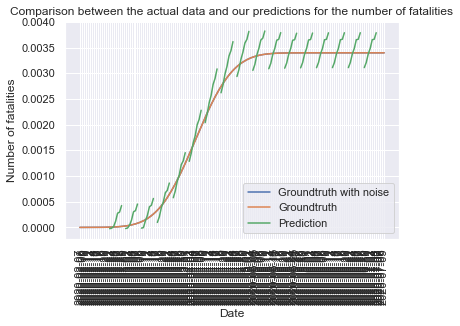

------------------------------SIR-small-82---------------------------------


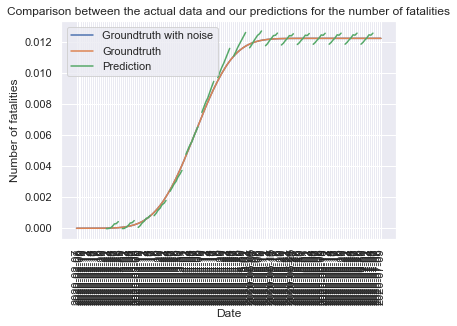

------------------------------SIR-small-83---------------------------------


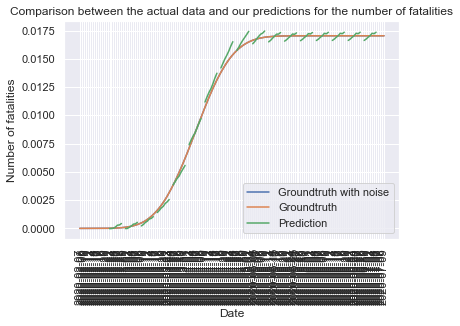

------------------------------SIR-small-84---------------------------------


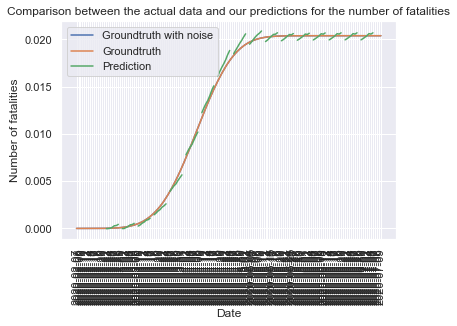

------------------------------SIR-small-85---------------------------------


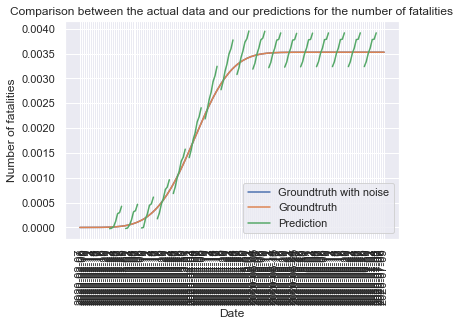

------------------------------SIR-small-86---------------------------------


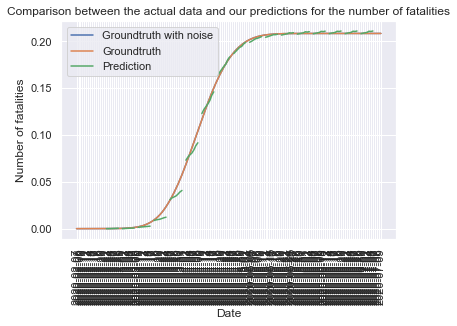

------------------------------SIR-small-87---------------------------------


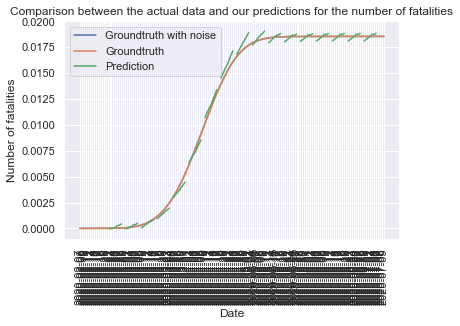

------------------------------SIR-small-88---------------------------------


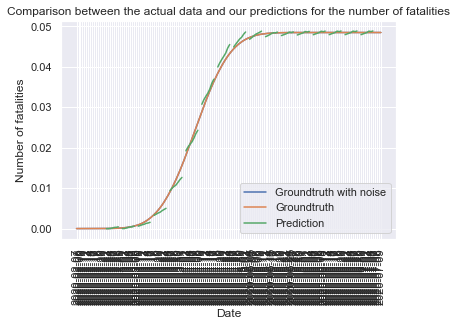

------------------------------SIR-small-89---------------------------------


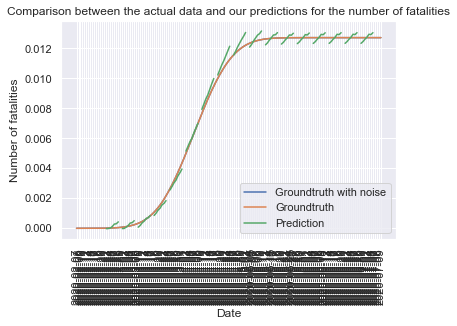

------------------------------SIR-small-90---------------------------------


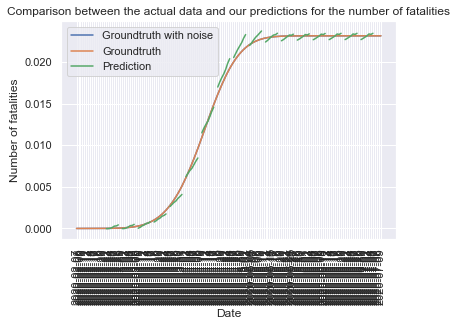

------------------------------SIR-small-91---------------------------------


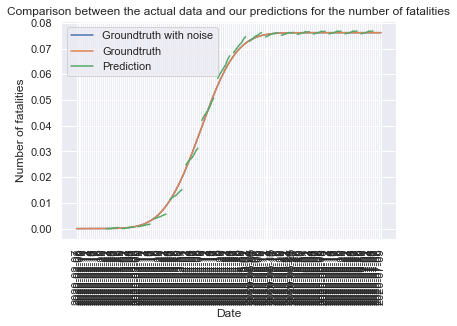

------------------------------SIR-small-92---------------------------------


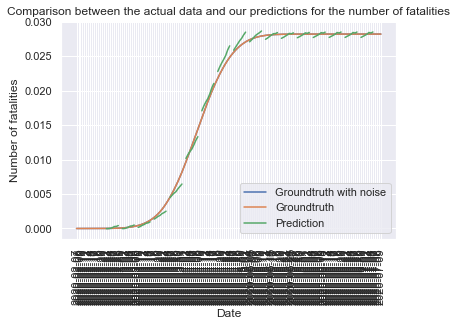

------------------------------SIR-small-93---------------------------------


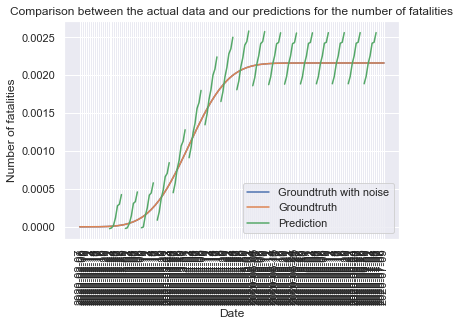

------------------------------SIR-small-94---------------------------------


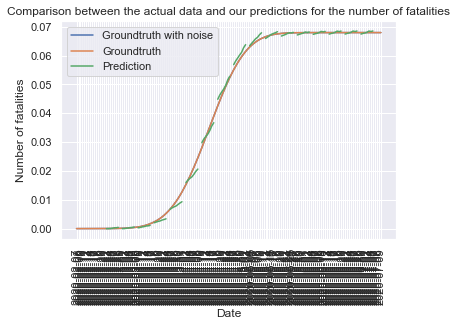

------------------------------SIR-small-95---------------------------------


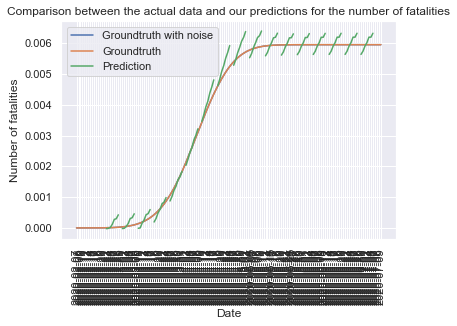

------------------------------SIR-small-96---------------------------------


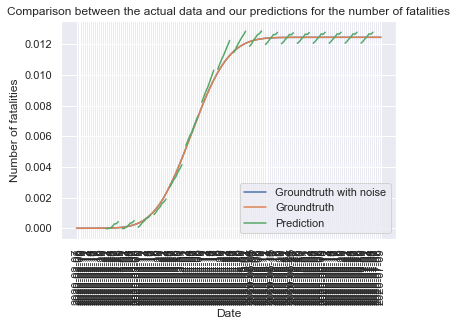

------------------------------SIR-small-97---------------------------------


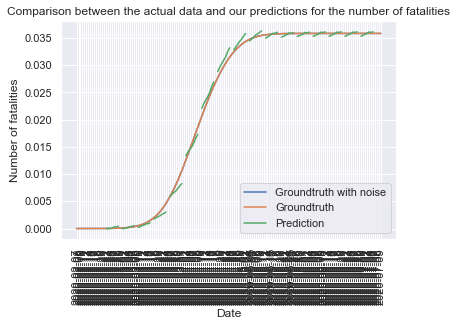

------------------------------SIR-small-98---------------------------------


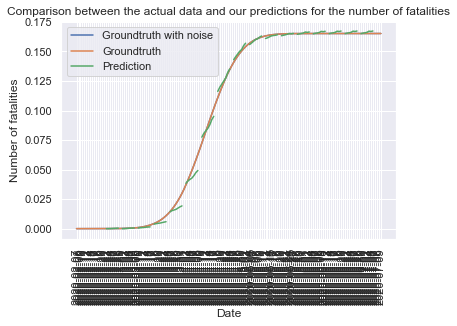

------------------------------SIR-small-99---------------------------------


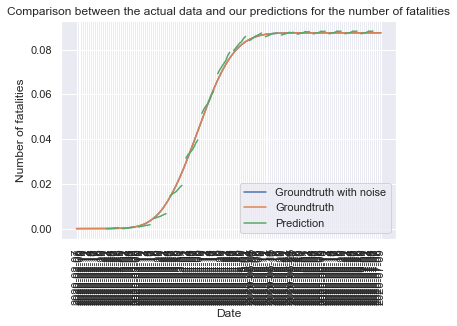

In [21]:
for code in range(81, 100):
    print("------------------------------SIR-small-{}---------------------------------".format(code))
    display_comparison_SIR("SIR-small-{}".format(code), pdf, gdf)

In [ ]:
for code in test_country:
    print("------------------------------{}---------------------------------".format(code))
    display_comparison_region(code, cpdf, cgdf)